In [1]:
from abc import ABC, abstractmethod
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt

from gpytorch.optim import NGD
from gpytorch.mlls import VariationalELBO
from torch.optim import Adam
from torch.nn import Parameter
from torch.nn import Module
from gpytorch.constraints import Positive, Interval

In [44]:
class MultitaskGP(gpytorch.models.ExactGP):
    """ 
    Multitask GP model class.
    Used for multitask GP regression on latent functions
    in the latent force model.

    Args:
        X (torch.Tensor): training data (time points)
        y (torch.Tensor): target data (latent forces)
        mean_module (gpytorch.means.Mean): mean module
        covar_module (gpytorch.kernels.Kernel): covariance module
    """
    def __init__(self,
                 X : torch.Tensor,
                 y : torch.Tensor,
                 mean_module : gpytorch.means.Mean,
                 covar_module : gpytorch.kernels.Kernel):
        
        super(MultitaskGP, self).__init__(train_inputs=X,
                                          train_targets=y,
                                          likelihood=gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=y.shape[1]))
        self.X = X
        self.mean_module = mean_module
        self.covar_module = covar_module
        self.likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=y.shape[1])

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)
    
    def predict(self, x):
        self.eval()
        self.likelihood.eval()

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            
            predictions = self.likelihood(self(x))
           
            mean = predictions.mean
            lower, upper = predictions.confidence_region()
            return mean, lower, upper
    
    def get_latents(self, x):
        self.eval()
        self.likelihood.eval()

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            return self.likelihood(self(x))

    def fit(self,
            n_iter : int,
            lr : float,
            optim : torch.optim.Optimizer,
            device : torch.device,
            verbose : bool = True):
        
        self.train()
        self.likelihood.train()
        
        self.to(device)
        self.likelihood.to(device)

        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self)
        optimizer = optim(self.parameters(), lr=lr)
        
        print_freq = n_iter // 10

        for i in range(n_iter):
            optimizer.zero_grad()
            output = self(self.X)
            loss = -mll(output, self.train_targets)
            loss.backward()
            optimizer.step()

            if (i+1) % print_freq == 0 and verbose:
                print(f'Iter {i+1} - Loss: {loss.item()}')


In [177]:
x = torch.linspace(0, torch.pi, 100)
y = torch.stack([torch.sin(x * 2 * torch.pi) + torch.randn(x.size(0)) * 0.2,
                 x*torch.cos(x * 2 * torch.pi) + torch.randn(x.size(0)) * 0.2,
                 (x-3/2)**3  +  torch.randn(x.size(0)) * 0.2,
                 -x + torch.randn(x.size(0))*0.2,
                ], -1)


# generate random weights from a normal distribution
w = torch.randn(4, 1)
z = y @ w + torch.randn(y.size(0), 1) * 0.1

z_train, z_test = z[:75], z[75:]

In [178]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=y.shape[1])
mean_module = gpytorch.means.MultitaskMean(
                    gpytorch.means.ConstantMean(),
                    num_tasks=y.shape[1]
                )
covar_module = gpytorch.kernels.MultitaskKernel(
                    gpytorch.kernels.RBFKernel(),
                    num_tasks=y.shape[1],
                    rank=1
                )
multitask_model = MultitaskGP(X=x,
                              y=y, 
                              mean_module=mean_module, 
                              covar_module=covar_module)
multitask_model.fit(n_iter=100, 
                    lr=0.1, 
                    optim=Adam, 
                    device=torch.device('cpu'), 
                    verbose=True)

Iter 10 - Loss: 1.0065997838974
Iter 20 - Loss: 0.639197587966919
Iter 30 - Loss: 0.29259803891181946
Iter 40 - Loss: 0.12237343192100525
Iter 50 - Loss: 0.12312286347150803
Iter 60 - Loss: 0.10783065855503082
Iter 70 - Loss: 0.10489456355571747
Iter 80 - Loss: 0.10365302860736847
Iter 90 - Loss: 0.101873017847538
Iter 100 - Loss: 0.10040176659822464


In [179]:
def plot_multitask_gp(multitask_model, x, y):
    y_pred, lower, upper = multitask_model.predict(x)

    # create color array of length 10
    colors = plt.get_cmap('tab10').colors

    plt.rcParams['font.family'] = 'Arial'

    plt.figure(figsize=(12, 6))
    # plot each task
    for i in range(y.shape[1]):
        plt.plot(x.numpy(), y[:, i].numpy(), 'o', color=colors[i], fillstyle='none')
        plt.plot(x.numpy(), y_pred[:, i].numpy(), color=colors[i], label=f'Latent Force {i+1}')
        plt.fill_between(x.numpy(), lower[:, i].numpy(), upper[:, i].numpy(), color=colors[i], alpha=0.2)
    
    plt.xlabel('Time', fontsize=13)
    plt.ylabel('Latent Force', fontsize=13)

    plt.plot(x.numpy(), z.numpy(), color='black', fillstyle='none', label='Target')
    
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

/Users/eirikbaekkelund/opt/anaconda3/envs/gp/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


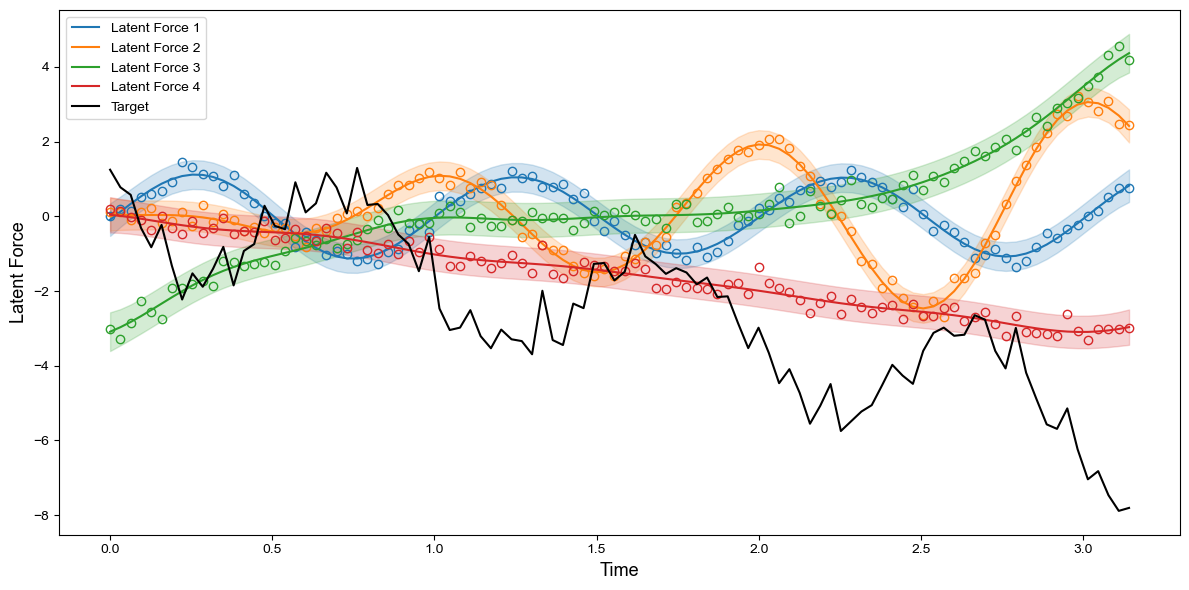

In [180]:
plot_multitask_gp(multitask_model, x, y)

In [52]:
from torchdiffeq import odeint

class LFMBase(Module):
    pass

class OrdinaryLFM(LFMBase, ABC):
    def __init__(self, 
                 X : torch.Tensor,
                 y : torch.Tensor,
                 gp_model : MultitaskGP,
                 num_outputs : int,
                 **kwargs):
        
        super(OrdinaryLFM, self).__init__()
        
        self.X = X
        self.y = y
        self.num_outputs = num_outputs
        self.gp_model = gp_model
        # TODO discuss how this will be with 
        # training vs testing data as we have 
        # test data for the latent forces 
        self.generate_latent_posteriors()
        
    def generate_latent_posteriors(self):
        # fit GP on latent data to get latent forces
        self.gp_model.fit(  n_iter=100,
                            lr=0.1,
                            optim=Adam,
                            device=torch.device('cpu'),
                            verbose=False)
        
    @abstractmethod
    def odefunc(self, t, x, **kwargs):
        """ 
        Define the ODE system to be solved
        
        Args:
            t (torch.Tensor): time
            x (torch.Tensor): latent forces
        """
        pass
    
    def forward(self, t, step_size=1, **kwargs):
        """ 
        Use the latent forces to make predictions on the ODE system
        for our target outputs
        """
        q_u = self.gp_model.get_latents(t)
        f = q_u.rsample((10,))
        print(f.shape)        
    
    def build_target_dist(self, t, h_samples):
        """
        Build a distribution for the target outputs
        """
        h_mean = h_samples.mean(dim=1)
        h_var = h_samples.var(dim=1) 

        # build a beta likelihood GP for the target output


In [ ]:
lfm_model = OrdinaryLFM(
                        